In [1]:
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import seaborn as sns
import time

from emd import emd
from kde.location_project.cmp import geodesic_dist
# from kde.location_project.kde_2d import kdnearest

sys.setrecursionlimit(10000)

%matplotlib inline
init_notebook_mode(connected=True)

%load_ext autoreload
%autoreload 2

pd.options.mode.chained_assignment = None # turn off SettingWithCopyWarning

np.random.seed(1234)
time_span = 'month'
n_visits = 20

# Geolocation Data - Twitter

NOTE: all of the results in the paper discussed B as fixed, but in this analysis A is fixed.

In [2]:
### OC
oc_directory = os.path.join("..", "data", "oc") 
oc = pd.read_csv(os.path.join(oc_directory, "visits_no_filter.csv"))
oc_deduped = pd.read_csv(os.path.join(oc_directory, "visits_deduped.csv"))
oc_mpp = pd.read_csv(os.path.join(oc_directory, "mpp_visits_month0a_month1b_n20.csv"))

print("Days:", oc['day_id'].nunique())
print("Accounts:", oc['user_id'].nunique())
print("Events: ", oc.shape[0], " (", round(oc.shape[0] / oc['user_id'].nunique(), 1), ")",sep="")
print("Visits: ", oc_deduped.shape[0], " (", round(oc_deduped.shape[0] / oc['user_id'].nunique(), 1), ")",sep="")
print("")
print("MPP DATA (at least {} visits in each of the first two {}s)".format(n_visits, time_span))
print("Users:", oc_mpp['uid'].nunique())
print("Visits: ", len(oc_mpp), " (", round(len(oc_mpp) / oc_mpp['uid'].nunique(), 1), ")",sep="")

Days: 240
Accounts: 103271
Events: 655917 (6.4)
Visits: 545697 (5.3)

MPP DATA (at least 20 visits in each of the first two months)
Users: 223
Visits: 28052 (125.8)


In [3]:
# location weights based on number of visits
oc_locs = oc_deduped.groupby('location_id')['event_id'].count()
oc_wt_e = pd.DataFrame(oc_locs).reset_index().rename(columns={'event_id': 'weight'})
oc_wt_e['weight'] = 1 / oc_wt_e['weight']

# location weights based on number of unique users at location
oc_locs_users = oc_deduped.groupby(['location_id'])['old_uid'].nunique()
oc_wt_u = pd.DataFrame(oc_locs_users).reset_index().rename(columns={'old_uid': 'weight'})
oc_wt_u['weight'] = 1 / oc_wt_u['weight']

# merge weights in to the point pattern data
oc_deduped = pd.merge(oc_deduped, oc_wt_e, on='location_id')
oc_deduped = pd.merge(oc_deduped, oc_wt_u, on='location_id', suffixes=('_event', '_user'))
oc_deduped.head()

,old_uid,uid,lon,lat,location_id,visit,month,event_id,weight_event,weight_user
0,294.0,-1.0,-117.88171,33.67500,112474.0,0,3.0,2851744.0,0.111111,0.166667
1,294.0,-1.0,-117.88171,33.67500,112474.0,1,3.0,8240773.0,0.111111,0.166667
2,7822352.0,-1.0,-117.88159,33.67472,112474.0,10,2.0,3995518.0,0.111111,0.166667
3,20964826.0,-1.0,-117.88171,33.67500,112474.0,15,3.0,8345505.0,0.111111,0.166667
4,31643612.0,-1.0,-117.88159,33.67512,112474.0,1,2.0,4677596.0,0.111111,0.166667


# Test KDE-based LR

In [4]:
from kde.location_project.kde_2d import (
    KDE,
    MixtureKDE,
    create_individual_component_data,
    learn_nearest_neighbors_bandwidth
)

### Create Population KDE

In [5]:
# learn the bandwidth for each point & save to file (it's expensive)
filepath = os.path.join("..", "data", "DFRWS_USA", "oc", "population_visits_kde_data.npy")

# points = oc_deduped.loc[:, ['lon', 'lat']].values
# bw_pop = learn_nearest_neighbors_bandwidth(points, k=5, min_bw=0.05)
# kde_data = np.hstack([points, np.atleast_2d(bw_pop).T])  # adaptive bandwidth
# kde_data = np.append(kde_data, np.ones((len(kde_data), 1)), 1)  # equal weights by default
# np.save(filepath, kde_data)

pop_kde_data = np.load(filepath)

## Perform LR computation incorporating marks

In [6]:
def calculate_lr(mpp, pop_kde_data, uA, uB):
    # get index of points in patterns A and B, respectively
    ind_A = (mpp.uid == uA )& (mpp.m == 'a')
    ind_B = (mpp.uid == uB) & (mpp.m == 'b')

    # create the mixture KDE
    i_kde_data = create_individual_component_data(mpp.loc[ind_A, ])
    i_kde = MixtureKDE(i_kde_data, pop_kde_data)

    # evaluate the points in question (pattern B)
    eval_points = mpp.loc[ind_B, ['lon', 'lat']].values
    pop_kde = KDE(pop_kde_data)
    
    return i_kde.log_lik(eval_points) - pop_kde.log_lik(eval_points)


calculate_lr(oc_mpp, pop_kde_data, uA=1, uB=2)

-56.68957101525383

In [7]:
calculate_lr(oc_mpp, pop_kde_data, uA=1, uB=1)

13.047291465108643

# Perform Test of LR Experiment

In [8]:
# import itertools

# ids = oc_mpp.uid.unique()
# samp_space = pd.DataFrame(itertools.product(ids, ids), columns=["a", "b"])
# d = samp_space.loc[samp_space.a != samp_space.b, ].sample(1000-223, random_state=1234)
# sample = pd.concat([samp_space.loc[samp_space.a == samp_space.b, ["a", "b"]], d]).reset_index(
#     drop=True
# )

# lr = []
# for index, row in sample.iterrows():
#     if index % round(len(sample) / 10) == 0:
#         print(round(index / len(sample), 1) * 100, "%")
#     tmp = {"a": row["a"], "b": row["b"]}
#     tmp["lr"] = calculate_lr(oc_mpp, pop_kde_data, uA=row["a"], uB=row["b"])
#     lr.append(tmp)
    
# lr = pd.DataFrame.from_dict(lr)

# lr.to_csv(
#     os.path.join("..", "data", "DFRWS_USA", "oc", "lr_alpha80.csv"),
#     index=False
# )

lr = pd.read_csv(os.path.join("..", "data", "DFRWS_USA", "oc", "lr_alpha80.csv"))
lr.head()

,a,b,lr
0,1,1,-8.835582
1,2,2,162.280836
2,3,3,416.939839
3,4,4,158.669085
4,5,5,-25.844216


In [9]:
from sklearn.metrics import roc_auc_score

def perf_measure(y_actual, y_hat):
    y_actual = list(y_actual)
    y_hat = list(y_hat)

    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1
    
    tpr = TP / (TP + FN)
    fpr = FP / (FP + TN)
    
    return (format(round(tpr, 3), '.3f'), format(round(fpr, 3), '.3f'))


def calc_auc(rslt, score, column='label'):
    return format(round(roc_auc_score(rslt[column], rslt[score]), 3), '.3f')

In [10]:
lr["same-src"] = (lr.a == lr.b).astype(bool)

print("TP/FP@1", perf_measure(lr['same-src'], lr['lr'] >= 0))
print("AUC", calc_auc(lr, 'lr', 'same-src'))

TP/FP@1 ('0.870', '0.003')
AUC 0.974


# Plot `n_A` vs LR

In [11]:
# merge weights in to the point pattern data
oc_mpp = pd.merge(oc_mpp, oc_wt_e, on='location_id')
oc_mpp = pd.merge(oc_mpp, oc_wt_u, on='location_id', suffixes=('_event', '_user'))
oc_mpp.head()

,old_uid,uid,m,lon,lat,location_id,weight_event,weight_user
0,2554741.0,1,a,-117.83335,33.74851,546927.0,0.008264,0.011905
1,67150220.0,60,a,-117.83335,33.74851,546927.0,0.008264,0.011905
2,2554741.0,1,a,-117.67779,33.47102,517182.0,0.025641,0.250000
3,2554741.0,1,a,-117.67779,33.47102,517182.0,0.025641,0.250000
4,2554741.0,1,a,-117.67779,33.47102,517182.0,0.025641,0.250000


In [12]:
tot_wts = oc_mpp.groupby(['uid', 'm']).agg({'lon': lambda x: len(x),
                                            'weight_event': sum,
                                            'weight_user': sum}).reset_index()
tot_wts = tot_wts.rename(columns={'lon': 'n_a'})
tot_wts = tot_wts[tot_wts.m == 'a']
tot_wts.head()

,uid,m,n_a,weight_event,weight_user
0,1,a,23.0,1.729560,4.307912
2,2,a,48.0,0.587924,16.002281
4,3,a,114.0,4.363294,8.107045
6,4,a,42.0,1.758149,22.332050
8,5,a,37.0,0.356989,0.700829


In [13]:
lr = pd.merge(lr, tot_wts, how="left", left_on="a", right_on="uid")
lr = lr.drop(columns=["uid", "m"])
lr.head()

,a,b,lr,same-src,n_a,weight_event,weight_user
0,1,1,-8.835582,True,23.0,1.729560,4.307912
1,2,2,162.280836,True,48.0,0.587924,16.002281
2,3,3,416.939839,True,114.0,4.363294,8.107045
3,4,4,158.669085,True,42.0,1.758149,22.332050
4,5,5,-25.844216,True,37.0,0.356989,0.700829


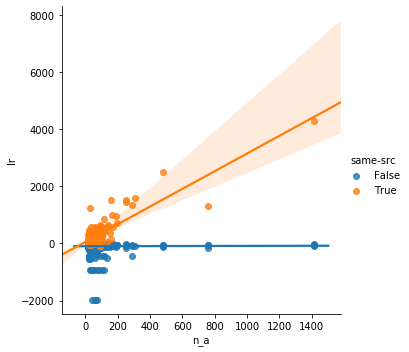

In [14]:
ax = sns.lmplot(x="n_a", y="lr", hue="same-src", data=lr)

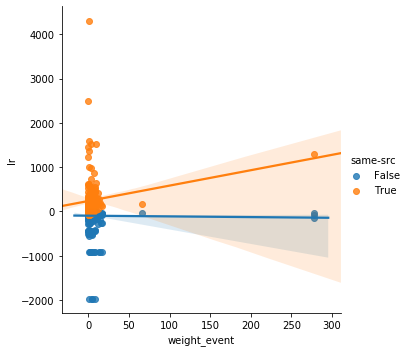

In [15]:
ax = sns.lmplot(x="weight_event", y="lr", hue="same-src", data=lr)

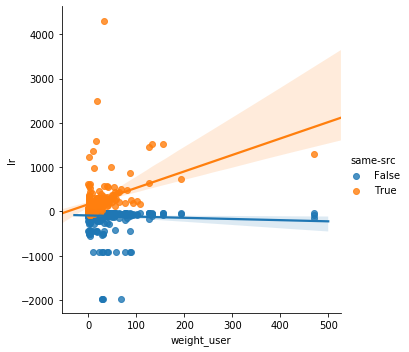

In [16]:
ax = sns.lmplot(x="weight_user", y="lr", hue="same-src", data=lr)

In [17]:
oc_directory = os.path.join("..", "data", "oc") 
slr = pd.read_csv(os.path.join(oc_directory, "slr_even_less_junk.csv"))
cmp = pd.read_csv(os.path.join(oc_directory, "cmp_population_even_less_junk.csv"))


### SLR

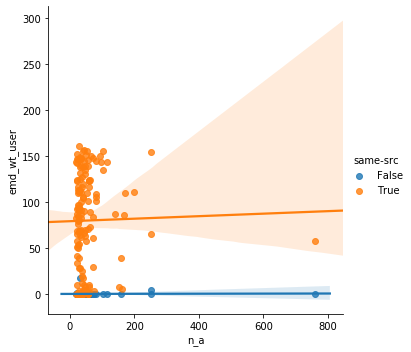

In [18]:
rslt = pd.merge(lr, slr, on=['a', 'b'])
ax = sns.lmplot(x="n_a", y="emd_wt_user", hue="same-src", data=rslt)

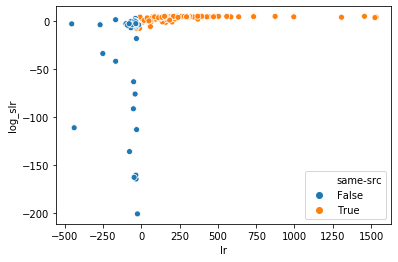

In [19]:
rslt["log_slr"] = np.log(rslt.emd_wt_user)
ax = sns.scatterplot(x="lr", y="log_slr", hue="same-src", data=rslt)

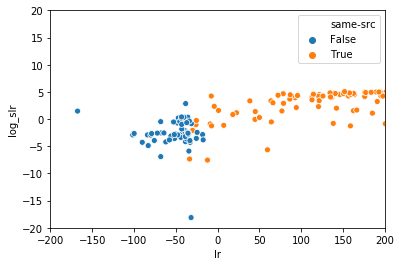

In [20]:
ax = sns.scatterplot(x="lr", y="log_slr", hue="same-src", data=rslt).set(xlim=[-200, 200], ylim=[-20, 20])
plt.show()

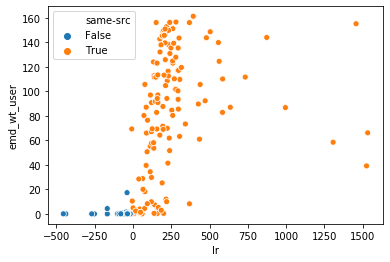

In [21]:
ax = sns.scatterplot(x="lr", y="emd_wt_user", hue="same-src", data=rslt)
plt.plot([0, 0], [1, 1], linewidth=2)

### CMP

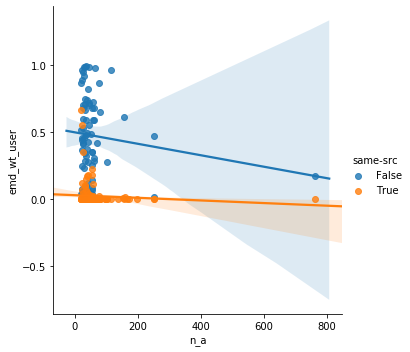

In [22]:
rslt = pd.merge(lr, cmp, on=['a', 'b'])
ax = sns.lmplot(x="n_a", y="emd_wt_user", hue="same-src", data=rslt)

# Extend experiement to users with less data

In [23]:
directory = os.path.join("..", "data", "DFRWS_USA", "oc")
n_visits = 1
mpp = pd.read_csv(os.path.join(directory, "mpp_visits_month0a_month1b_n1.csv"))
print("MPP DATA (at least {} visits in each of the first two {}s)".format(n_visits, time_span))
print("Users: ", mpp['uid'].nunique())
print("Visits: ", len(mpp), " (", round(len(mpp) / mpp['uid'].nunique(), 1), ")",sep="")
ind_A = mpp.m == 'a'
print("n_A: ", len(mpp.loc[ind_A]), " (", round(len(mpp.loc[ind_A]) / mpp['uid'].nunique(), 1), ")",sep="")
ind_B = mpp.m == 'b'
print("n_B: ", len(mpp.loc[ind_B]), " (", round(len(mpp.loc[ind_B]) / mpp['uid'].nunique(), 1), ")",sep="")


MPP DATA (at least 1 visits in each of the first two months)
Users:  6714
Visits: 83007 (12.4)
n_A: 44310 (6.6)
n_B: 38697 (5.8)


In [24]:
# merge weights in to the point pattern data
mpp = pd.merge(mpp, oc_wt_e, on='location_id')
mpp = pd.merge(mpp, oc_wt_u, on='location_id', suffixes=('_event', '_user'))
mpp.head()

,old_uid,uid,m,lon,lat,location_id,weight_event,weight_user
0,2057.0,1,a,-117.72635,33.60057,6548.0,0.166667,0.166667
1,2057.0,1,b,-117.93499,33.70030,150705.0,0.076923,0.125000
2,25099775.0,1009,b,-117.93504,33.70028,150705.0,0.076923,0.125000
3,2057.0,1,b,-117.83536,33.83125,455162.0,0.029412,0.031250
4,15024696.0,207,a,-117.83569,33.83189,455162.0,0.029412,0.031250


### Create sample for experiment

In [25]:
# import itertools 
# np.random.seed(1234)
# splits = [1, 2, 20, float("inf")]

# # create all pairwise combinations
# ids = mpp.uid.unique()
# samp_space = pd.DataFrame(itertools.product(ids, ids), columns=["a", "b"])

# # merge in counts of events in A
# cts = mpp.groupby(['uid', 'm']).count().reset_index()
# cts = cts.loc[cts.m == 'a', ]
# cts = cts.rename(columns={"old_uid": "n_a"})
# cts.n_a.describe()
# samp_space = pd.merge(samp_space, cts[['uid', 'n_a']], left_on='a', right_on='uid').drop(columns="uid")

# # merge in counts of events in B
# cts = mpp.groupby(['uid', 'm']).count().reset_index()
# cts = cts.loc[cts.m == 'b', ]
# cts = cts.rename(columns={"old_uid": "n_b"})
# cts.n_b.describe()
# samp_space = pd.merge(samp_space, cts[['uid', 'n_b']], left_on='b', right_on='uid').drop(columns="uid")

# # bin the number of events in A and B for stratified sampling
# samp_space['bin_a'] = pd.cut(samp_space.n_a, bins=splits, right=False)
# samp_space['bin_b'] = pd.cut(samp_space.n_b, bins=splits, right=False)

# # sample 1000 pairs per combination of bins
# sample = samp_space.loc[samp_space.a != samp_space.b,].groupby(['bin_a', 'bin_b']).apply(lambda x: x.sample(1000))
# sample.index = sample.index.droplevel(0)
# sample.index = sample.index.droplevel(0)

# # add in same-source pairs
# sample = pd.concat([samp_space.loc[samp_space.a == samp_space.b,], sample], sort=True).reset_index(drop=True)

# # sample properties
# sample.groupby(['bin_a', 'bin_b'])['a'].count()
# samp_space.loc[samp_space.a == samp_space.b,].groupby(['bin_a', 'bin_b']).count()

### Compute scores for SLR & CMP computations 

In [26]:
from emd import emd
from kde.location_project.cmp import geodesic_dist


def get_user(mpp, uid, mark):
    out = mpp.copy()
    # out = out.drop_duplicates(subset=["location_id", "m"])
    return out.loc[(out.uid == uid) & (out.m == mark)].reset_index(drop=True)


def population_scores(mpp, keeps):
    rslt = []    
    for index, row in keeps.iterrows():
        user_A = row["a"]
        user_B = row["b"]
        tmp = {}
        try:
            ### get the data for the pair in question
            tmp['a'] = user_A
            tmp['b'] = user_B
            uA = get_user(mpp, user_A, 'a')
            uB = get_user(mpp, user_B, 'b')

            ### compute weights
            uA_wt_e = (uA['weight_event'] / sum(uA['weight_event'])).to_numpy()
            uA_wt_u = (uA['weight_user'] / sum(uA['weight_user'])).to_numpy()
            uB_wt_e = (uB['weight_event'] / sum(uB['weight_event'])).to_numpy()
            uB_wt_u = (uB['weight_user'] / sum(uB['weight_user'])).to_numpy()

            ### compute the distance matrix & IED scores
            dist = geodesic_dist(uA[['lat', 'lon']], uB[['lat', 'lon']])
            ied = dist.min(1)
            tmp['ied_med'] = np.median(ied)
            tmp['ied_mn'] = np.average(ied)
            tmp['ied_mn_wt_event'] = np.average(ied, weights=uA_wt_e)
            tmp['ied_mn_wt_user'] = np.average(ied, weights=uA_wt_u)

            ### compute variants of EMD
            tmp['emd'] = emd(distance="precomputed", D=dist)
            tmp['emd_wt_event'] = emd(
                X_weights=uA_wt_e, Y_weights=uB_wt_e, distance="precomputed", D=dist
            )
            tmp['emd_wt_user'] = emd(
                X_weights=uA_wt_u, Y_weights=uB_wt_u, distance="precomputed", D=dist
            )

            ### store it
            rslt.append(tmp)
        except:
            print(f"Error! A = {user_A}, B = {user_B}")
            continue
    return pd.DataFrame(rslt)


# oc_rslt = population_scores(mpp, sample)
# oc_rslt.to_csv(os.path.join(directory, "score_func_vals.csv"), index=False)

In [27]:
oc_rslt = pd.read_csv(os.path.join(directory, "score_func_vals.csv"))
oc_rslt.head()

,a,b,ied_med,ied_mn,ied_mn_wt_event,ied_mn_wt_user,emd,emd_wt_event,emd_wt_user
0,1,1,22.291881,22.291881,22.291881,22.291881,24.900571,23.734986,23.335357
1,1009,1009,8.082238,8.443559,12.186550,11.995258,9.215650,12.212204,12.011383
2,207,207,0.457699,1.825209,1.445924,1.206043,5.284902,12.375877,9.655803
3,2231,2231,6.569074,7.122262,5.754189,5.006451,7.122262,5.754189,5.006451
4,3604,3604,0.030067,0.508251,1.564566,0.666724,2.797701,7.570990,3.573957


## Analyze Results

In [28]:
def slr_classifier_performance_for_tex(rslt):
    print("& $\Delta$ & Weights &  TP@1  & FP@1  & AUC \\\\")
    print("\\hline")
    print(
        "& $\mean{D}_{min}$ & Uniform & ", 
        "{0[0]} & {0[1]}".format(perf_measure(rslt['label'], rslt['ied_mn'] > 1)), "&", 
        calc_auc(rslt,'ied_mn'), "\\\\"
    ) 
    print(
        "& $\mean{D}_{min}$ & Account  & ",
        "{0[0]} & {0[1]}".format(perf_measure(rslt['label'], rslt['ied_mn_wt_user'] > 1)), "&", 
        calc_auc(rslt,'ied_mn_wt_user'), "\\\\"
    )
    print(
        "& $\mean{D}_{min}$ & Visit    & ", 
        "{0[0]} & {0[1]}".format(perf_measure(rslt['label'], rslt['ied_mn_wt_event'] > 1)), "&", 
        calc_auc(rslt,'ied_mn_wt_event'), "\\\\"
    )
    print(
        "& EMD & Uniform & ", 
        "{0[0]} & {0[1]}".format(perf_measure(rslt['label'], rslt['emd'] > 1)), "&", 
        calc_auc(rslt,'emd'), "\\\\"
    )
    print(
        "& EMD  & Account & ", 
        "{0[0]} & {0[1]}".format(perf_measure(rslt['label'], rslt['emd_wt_user'] > 1)), "&", 
        calc_auc(rslt,'emd_wt_user'), "\\\\"
    )
    print(
        "& EMD  & Visit  & ", 
        "{0[0]} & {0[1]}".format(perf_measure(rslt['label'], rslt['emd_wt_event'] > 1)), "&", 
        calc_auc(rslt,'emd_wt_event'), "\\\\"
    )

    

def cmp_classifier_performance_for_tex(rslt):
    print("& $\Delta$ & Weights & TP@0.05  & TP@0.01 & AUC    ")
    print("\\hline")
    print(
        "& $\mean{D}_{min}$ & Uniform  & ", 
        perf_measure(~rslt['label'], rslt['ied_mn'] < 0.05)[0], "  &",
        perf_measure(~rslt['label'], rslt['ied_mn'] < 0.01)[0], "  &",
        calc_auc(rslt,'ied_mn'), "\\\\"
    ) 
    print(
        "& $\mean{D}_{min}$ & Account & ",
        perf_measure(~rslt['label'], rslt['ied_mn_wt_user'] < 0.05)[0], "  &",
        perf_measure(~rslt['label'], rslt['ied_mn_wt_user'] < 0.01)[0], "  &",
        calc_auc(rslt,'ied_mn_wt_user'), "\\\\"
    )
    print(
        "& $\mean{D}_{min}$ & Visit & ", 
        perf_measure(~rslt['label'], rslt['ied_mn_wt_event'] < 0.05)[0], "  &",
        perf_measure(~rslt['label'], rslt['ied_mn_wt_event'] < 0.01)[0], "  &",
        calc_auc(rslt,'ied_mn_wt_event'), "\\\\"
    )
    print(
        "& EMD & Uniform & ", 
        perf_measure(~rslt['label'], rslt['emd'] < 0.05)[0], "  &",
        perf_measure(~rslt['label'], rslt['emd'] < 0.01)[0], "  &",
        calc_auc(rslt,'emd'), "\\\\"
    )
    print(
        "& EMD & Account & ",
        perf_measure(~rslt['label'], rslt['emd_wt_user'] < 0.05)[0], "  &",
        perf_measure(~rslt['label'], rslt['emd_wt_user'] < 0.01)[0], "  &",
        calc_auc(rslt,'emd_wt_user'), "\\\\"
    )
    print(
        "& EMD & Visit & ", 
        perf_measure(~rslt['label'], rslt['emd_wt_event'] < 0.05)[0], "  &",
        perf_measure(~rslt['label'], rslt['emd_wt_event'] < 0.01)[0], "  &",
        calc_auc(rslt,'emd_wt_event'), "\\\\"
    )

In [29]:
directory = os.path.join("..", "data", "DFRWS_USA", "oc")
slr = pd.read_csv(os.path.join(directory, "slr.csv"))
cmp = pd.read_csv(os.path.join(directory, "cmp.csv"))
lr = pd.read_csv(os.path.join(directory, "lr.csv"))

slr["same-src"] = (slr.a == slr.b).astype(bool)
cmp["same-src"] = (cmp.a == cmp.b).astype(bool)
lr["same-src"] = (lr.a == lr.b).astype(bool)

In [30]:
print("TP/FP@1", perf_measure(lr['same-src'], lr['lr_alpha_vary'] >= 0))
print("AUC", calc_auc(lr, 'lr_alpha_vary', 'same-src'))

TP/FP@1 ('0.380', '0.038')
AUC 0.845


In [31]:
print("TP/FP@1", perf_measure(lr['same-src'], lr['lr_alpha_80'] >= 0))
print("AUC", calc_auc(lr, 'lr_alpha_80', 'same-src'))

TP/FP@1 ('0.340', '0.026')
AUC 0.787


In [32]:
slr['label'] = (slr.a == slr.b).astype(bool)  # same-src has larger slr
slr_classifier_performance_for_tex(slr)

& $\Delta$ & Weights &  TP@1  & FP@1  & AUC \\
\hline
& $\mean{D}_{min}$ & Uniform &  0.628 & 0.202 & 0.768 \\
& $\mean{D}_{min}$ & Account  &  0.610 & 0.171 & 0.774 \\
& $\mean{D}_{min}$ & Visit    &  0.611 & 0.180 & 0.768 \\
& EMD & Uniform &  0.654 & 0.197 & 0.790 \\
& EMD  & Account &  0.614 & 0.162 & 0.783 \\
& EMD  & Visit  &  0.602 & 0.169 & 0.774 \\


In [33]:
cmp['label'] = (cmp.a != cmp.b).astype(bool)  # same-src has larger slr
cmp_classifier_performance_for_tex(cmp)

& $\Delta$ & Weights & TP@0.05  & TP@0.01 & AUC    
\hline
& $\mean{D}_{min}$ & Uniform  &  0.389   & 0.187   & 0.771 \\
& $\mean{D}_{min}$ & Account &  0.441   & 0.236   & 0.776 \\
& $\mean{D}_{min}$ & Visit &  0.415   & 0.209   & 0.771 \\
& EMD & Uniform &  0.397   & 0.154   & 0.791 \\
& EMD & Account &  0.448   & 0.208   & 0.784 \\
& EMD & Visit &  0.425   & 0.182   & 0.775 \\


## Accuracy by bin

In [34]:
# get counts of events in A & B
cts = mpp.groupby(['uid', 'm']).count().reset_index()

cts_a = cts.loc[cts.m == 'a', ]
cts_a = cts_a.rename(columns={"old_uid": "n_a"})
cts_a = cts_a[['uid', 'n_a']]

cts_b = cts.loc[cts.m == 'b', ]
cts_b = cts_b.rename(columns={"old_uid": "n_b"})
cts_b = cts_b[['uid', 'n_b']]

### LR Methods

In [35]:
score_func = "lr_alpha_80"
print("TP/FP@1", perf_measure(lr['same-src'], lr[score_func] > 0))
print("AUC", calc_auc(lr, score_func, 'same-src'))

TP/FP@1 ('0.340', '0.026')
AUC 0.787


In [36]:
# merge & bin counts
lr = pd.merge(lr, cts_a, left_on="a", right_on="uid").drop(columns="uid")
lr = pd.merge(lr, cts_b, left_on="b", right_on="uid").drop(columns="uid")

splits = [1, 2, 20, float("inf")]
lr['bin_a'] = pd.cut(lr.n_a, bins=splits, right=False)
lr['bin_b'] = pd.cut(lr.n_b, bins=splits, right=False)

In [37]:
lr.groupby(['bin_a', 'bin_b'])['a'].count()

bin_a        bin_b      
[1.0, 2.0)   [1.0, 2.0)     2206
             [2.0, 20.0)    1933
             [20.0, inf)    1003
[2.0, 20.0)  [1.0, 2.0)     2224
             [2.0, 20.0)    3869
             [20.0, inf)    1086
[20.0, inf)  [1.0, 2.0)     1016
             [2.0, 20.0)    1154
             [20.0, inf)    1223
Name: a, dtype: int64

In [38]:
lr.groupby(['bin_a', 'bin_b']).apply(lambda x: calc_auc(x, score_func, 'same-src'))

bin_a        bin_b      
[1.0, 2.0)   [1.0, 2.0)     0.666
             [2.0, 20.0)    0.795
             [20.0, inf)    0.748
[2.0, 20.0)  [1.0, 2.0)     0.687
             [2.0, 20.0)    0.744
             [20.0, inf)    0.953
[20.0, inf)  [1.0, 2.0)     0.842
             [2.0, 20.0)    0.900
             [20.0, inf)    0.978
dtype: object

In [39]:
lr.groupby(['bin_a', 'bin_b']).apply(lambda x: perf_measure(x['same-src'], x[score_func] > 0))

bin_a        bin_b      
[1.0, 2.0)   [1.0, 2.0)     (0.187, 0.018)
             [2.0, 20.0)    (0.235, 0.011)
             [20.0, inf)    (0.333, 0.007)
[2.0, 20.0)  [1.0, 2.0)     (0.272, 0.064)
             [2.0, 20.0)    (0.383, 0.042)
             [20.0, inf)    (0.744, 0.009)
[20.0, inf)  [1.0, 2.0)     (0.625, 0.043)
             [2.0, 20.0)    (0.825, 0.029)
             [20.0, inf)    (0.910, 0.007)
dtype: object

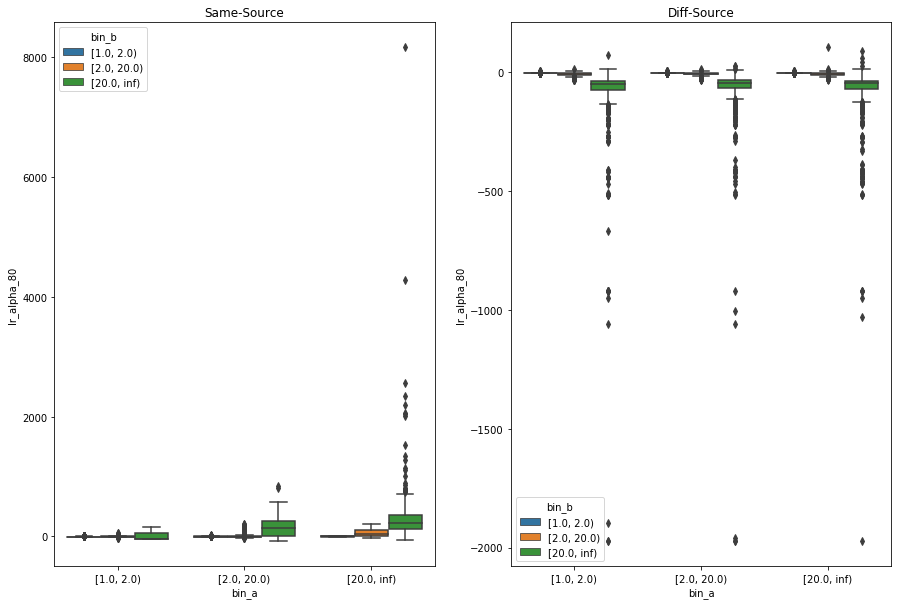

In [40]:
f, axes = plt.subplots(1, 2, figsize=(15,10))
sns.boxplot(y=score_func, x="bin_a", data=lr.loc[lr["same-src"] == True], hue="bin_b", ax=axes[0]).set_title("Same-Source")
sns.boxplot(y=score_func, x="bin_a", data=lr.loc[lr["same-src"] == False], hue="bin_b", ax=axes[1]).set_title("Diff-Source")
plt.show()


### SLR Methods

In [41]:
score_func = 'emd_wt_user'
print("TP/FP@1", perf_measure(slr['same-src'], slr[score_func] > 1))
print("AUC", calc_auc(slr, score_func, 'same-src'))

TP/FP@1 ('0.614', '0.162')
AUC 0.783


In [42]:
# merge & bin counts
slr = pd.merge(slr, cts_a, left_on="a", right_on="uid").drop(columns="uid")
slr = pd.merge(slr, cts_b, left_on="b", right_on="uid").drop(columns="uid")

splits = [1, 2, 20, float("inf")]
slr['bin_a'] = pd.cut(slr.n_a, bins=splits, right=False)
slr['bin_b'] = pd.cut(slr.n_b, bins=splits, right=False)

slr.head()

,a,b,ied_med,ied_mn,ied_mn_wt_event,ied_mn_wt_user,emd,emd_wt_event,emd_wt_user,same-src,label,n_a,n_b,bin_a,bin_b
0,1.0,1.0,0.357808,0.348943,0.351755,0.357431,0.300935,0.390402,0.398849,True,True,1,2,"[1.0, 2.0)","[2.0, 20.0)"
1,2310.0,1.0,0.248014,0.232466,0.223155,0.207772,0.169987,0.249149,0.235155,False,False,42,2,"[20.0, inf)","[2.0, 20.0)"
2,1.0,5679.0,0.582882,0.630841,0.608088,0.586331,0.987651,0.891648,0.846269,False,False,1,1,"[1.0, 2.0)","[1.0, 2.0)"
3,806.0,5679.0,0.400286,0.381784,0.399066,0.393618,0.379129,0.442828,0.432398,False,False,1,1,"[1.0, 2.0)","[1.0, 2.0)"
4,5679.0,5679.0,3.608145,4.000391,4.044515,4.015830,7.829822,8.272461,8.420063,True,True,1,1,"[1.0, 2.0)","[1.0, 2.0)"


In [43]:
slr.groupby(['bin_a', 'bin_b']).apply(lambda x: calc_auc(x, score_func, 'same-src'))

bin_a        bin_b      
[1.0, 2.0)   [1.0, 2.0)     0.690
             [2.0, 20.0)    0.717
             [20.0, inf)    0.596
[2.0, 20.0)  [1.0, 2.0)     0.749
             [2.0, 20.0)    0.817
             [20.0, inf)    0.919
[20.0, inf)  [1.0, 2.0)     0.821
             [2.0, 20.0)    0.945
             [20.0, inf)    0.969
dtype: object

In [44]:
slr.groupby(['bin_a', 'bin_b']).apply(lambda x: perf_measure(x['same-src'], x[score_func] > 1))

bin_a        bin_b      
[1.0, 2.0)   [1.0, 2.0)     (0.539, 0.257)
             [2.0, 20.0)    (0.546, 0.178)
             [20.0, inf)    (0.333, 0.158)
[2.0, 20.0)  [1.0, 2.0)     (0.579, 0.195)
             [2.0, 20.0)    (0.639, 0.143)
             [20.0, inf)    (0.837, 0.126)
[20.0, inf)  [1.0, 2.0)     (0.688, 0.162)
             [2.0, 20.0)    (0.851, 0.125)
             [20.0, inf)    (0.928, 0.113)
dtype: object

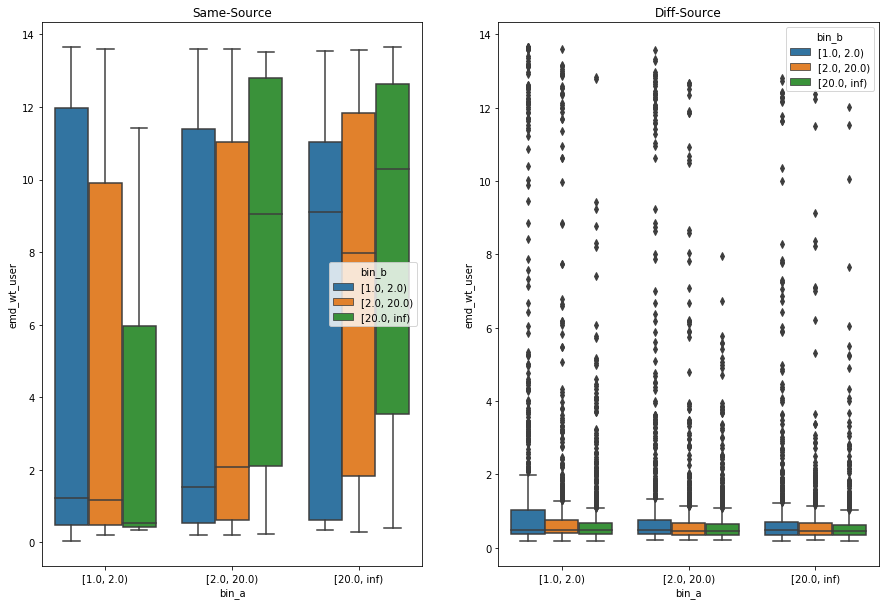

In [45]:
f, axes = plt.subplots(1, 2, figsize=(15,10))
sns.boxplot(y=score_func, x="bin_a", data=slr.loc[slr["same-src"] == True], hue="bin_b", ax=axes[0]).set_title("Same-Source")
sns.boxplot(y=score_func, x="bin_a", data=slr.loc[slr["same-src"] == False], hue="bin_b", ax=axes[1]).set_title("Diff-Source")
plt.show()

### CMP Methods

In [46]:
print("TP/FP@1", perf_measure(cmp['same-src'], cmp[score_func] < .05))
print("AUC", calc_auc(cmp, score_func, 'label'))

TP/FP@1 ('0.448', '0.050')
AUC 0.784


In [47]:
# merge & bin counts
cmp = pd.merge(cmp, cts_a, left_on="a", right_on="uid").drop(columns="uid")
cmp = pd.merge(cmp, cts_b, left_on="b", right_on="uid").drop(columns="uid")

splits = [1, 2, 20, float("inf")]
cmp['bin_a'] = pd.cut(cmp.n_a, bins=splits, right=False)
cmp['bin_b'] = pd.cut(cmp.n_b, bins=splits, right=False)

cmp.head()

,a,b,ied_med,ied_mn,ied_mn_wt_event,ied_mn_wt_user,emd,emd_wt_event,emd_wt_user,same-src,label,n_a,n_b,bin_a,bin_b
0,1.0,1.0,0.801511,0.804401,0.789398,0.786953,0.783841,0.726384,0.714826,True,False,1,2,"[1.0, 2.0)","[2.0, 20.0)"
1,2310.0,1.0,0.973189,0.967182,0.967405,0.968517,0.971966,0.959951,0.958060,False,True,42,2,"[20.0, inf)","[2.0, 20.0)"
2,1.0,5679.0,0.374097,0.360645,0.353974,0.354530,0.200556,0.197999,0.195553,False,True,1,1,"[1.0, 2.0)","[1.0, 2.0)"
3,806.0,5679.0,0.746581,0.749805,0.731903,0.732792,0.647059,0.613588,0.615145,False,True,1,1,"[1.0, 2.0)","[1.0, 2.0)"
4,5679.0,5679.0,0.061583,0.052357,0.050578,0.051356,0.023010,0.019453,0.019564,True,False,1,1,"[1.0, 2.0)","[1.0, 2.0)"


In [48]:
score_func = 'emd_wt_user'
cmp.groupby(['bin_a', 'bin_b']).apply(lambda x: calc_auc(x, score_func, 'label'))

bin_a        bin_b      
[1.0, 2.0)   [1.0, 2.0)     0.692
             [2.0, 20.0)    0.719
             [20.0, inf)    0.566
[2.0, 20.0)  [1.0, 2.0)     0.751
             [2.0, 20.0)    0.818
             [20.0, inf)    0.920
[20.0, inf)  [1.0, 2.0)     0.806
             [2.0, 20.0)    0.946
             [20.0, inf)    0.970
dtype: object

In [49]:
cmp.groupby(['bin_a', 'bin_b']).apply(lambda x: perf_measure(x['same-src'], x[score_func] < 0.05))

bin_a        bin_b      
[1.0, 2.0)   [1.0, 2.0)     (0.404, 0.132)
             [2.0, 20.0)    (0.362, 0.063)
             [20.0, inf)    (0.333, 0.038)
[2.0, 20.0)  [1.0, 2.0)     (0.421, 0.074)
             [2.0, 20.0)    (0.460, 0.040)
             [20.0, inf)    (0.674, 0.025)
[20.0, inf)  [1.0, 2.0)     (0.562, 0.046)
             [2.0, 20.0)    (0.695, 0.016)
             [20.0, inf)    (0.780, 0.017)
dtype: object

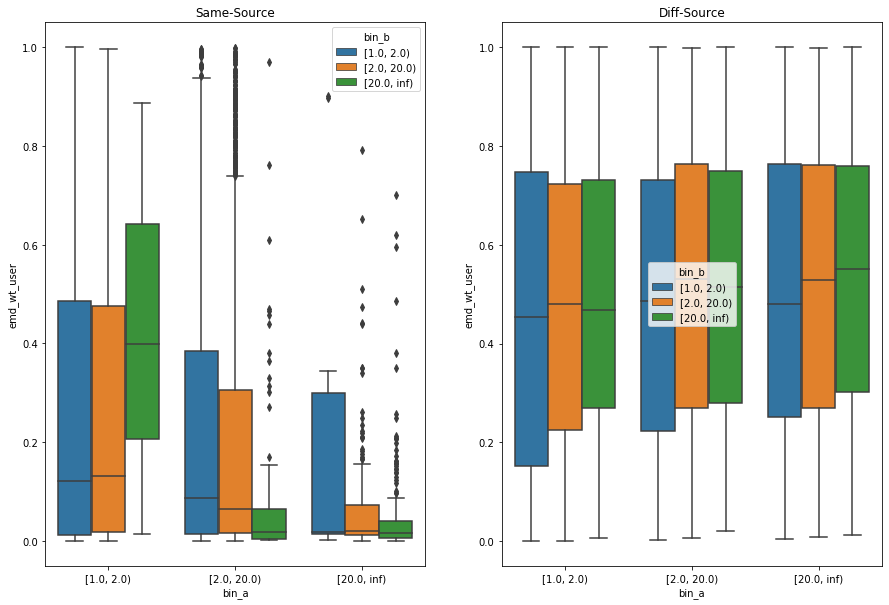

In [50]:
f, axes = plt.subplots(1, 2, figsize=(15,10))
sns.boxplot(y=score_func, x="bin_a", data=cmp.loc[cmp["same-src"] == True], hue="bin_b", ax=axes[0]).set_title("Same-Source")
sns.boxplot(y=score_func, x="bin_a", data=cmp.loc[cmp["same-src"] == False], hue="bin_b", ax=axes[1]).set_title("Diff-Source")
plt.show()

# "Disneyland Problem" User

In [51]:
reduced_mpp = pd.read_csv(os.path.join(oc_directory, "mpp_visits_month0a_month1b_n20.csv"))
reduced_mpp.loc[reduced_mpp.uid == 10, 'old_uid']  # new uid was 10, need to find out what it is now

721    17504677.0
722    17504677.0
723    17504677.0
724    17504677.0
725    17504677.0
          ...    
778    17504677.0
779    17504677.0
780    17504677.0
781    17504677.0
782    17504677.0
Name: old_uid, Length: 62, dtype: float64

In [52]:
mpp.loc[mpp.old_uid == 17504677, ]  # so it is 446

,old_uid,uid,m,lon,lat,location_id,weight_event,weight_user
529,17504677.0,446,a,-117.91914,33.81058,61905.0,0.000014,0.000032
530,17504677.0,446,a,-117.91894,33.81276,61905.0,0.000014,0.000032
531,17504677.0,446,a,-117.91849,33.81063,61905.0,0.000014,0.000032
532,17504677.0,446,a,-117.92184,33.81165,61905.0,0.000014,0.000032
533,17504677.0,446,a,-117.92008,33.81101,61905.0,0.000014,0.000032
...,...,...,...,...,...,...,...,...
5844,17504677.0,446,b,-117.91999,33.80754,62149.0,0.000032,0.000065
8375,17504677.0,446,b,-117.91793,33.80664,8329.0,0.000374,0.000532
23657,17504677.0,446,a,-117.92471,33.81626,35678.0,0.020833,0.025641
31090,17504677.0,446,b,-117.91397,33.80596,8323.0,0.025641,0.028571


In [53]:
lr.loc[(lr.a == 446) & (lr.b == 446), ]

,a,b,lr_alpha_80,alpha,lr_alpha_vary,same-src,n_a,n_b,bin_a,bin_b
3425,446.0,446.0,33.414106,0.55,29.191322,True,38,24,"[20.0, inf)","[20.0, inf)"


# Plot TP & FP rates for the different methods binned by `n_A` & `n_B`

### Create the data set

In [54]:
def performance_stats(x, score_func, column, criteria):
    out = []
    for s in score_func:
        d = {}
        d['score'] = s
        d['auc'] = calc_auc(x, s, column)
        d['tp'], d['fp'] = perf_measure(x[column], x[s] > criteria)
        out.append(d)
    return pd.DataFrame(out)

lr_rslt = lr.groupby(['bin_a', 'bin_b']).apply(
    lambda x: performance_stats(x, ['lr_alpha_vary', 'lr_alpha_80'], 'same-src', 0) 
).reset_index()
lr_rslt['method'] = 'lr'
lr_rslt.drop(columns='level_2', inplace=True)
lr_rslt.head()


,bin_a,bin_b,score,auc,tp,fp,method
0,"[1.0, 2.0)","[1.0, 2.0)",lr_alpha_vary,0.676,0.187,0.018,lr
1,"[1.0, 2.0)","[1.0, 2.0)",lr_alpha_80,0.666,0.187,0.018,lr
2,"[1.0, 2.0)","[2.0, 20.0)",lr_alpha_vary,0.793,0.294,0.030,lr
3,"[1.0, 2.0)","[2.0, 20.0)",lr_alpha_80,0.795,0.235,0.011,lr
4,"[1.0, 2.0)","[20.0, inf)",lr_alpha_vary,0.736,0.333,0.041,lr


In [55]:
scores = ['ied_mn', 'ied_mn_wt_event', 'ied_mn_wt_user', 'emd', 'emd_wt_event', 'emd_wt_user']

slr_rslt = slr.groupby(['bin_a', 'bin_b']).apply(
    lambda x: performance_stats(x, scores, 'same-src', 1) 
).reset_index()
slr_rslt['method'] = 'slr'
slr_rslt.drop(columns='level_2', inplace=True)
slr_rslt.head()


,bin_a,bin_b,score,auc,tp,fp,method
0,"[1.0, 2.0)","[1.0, 2.0)",ied_mn,0.686,0.461,0.176,slr
1,"[1.0, 2.0)","[1.0, 2.0)",ied_mn_wt_event,0.687,0.449,0.165,slr
2,"[1.0, 2.0)","[1.0, 2.0)",ied_mn_wt_user,0.689,0.440,0.159,slr
3,"[1.0, 2.0)","[1.0, 2.0)",emd,0.690,0.566,0.292,slr
4,"[1.0, 2.0)","[1.0, 2.0)",emd_wt_event,0.690,0.547,0.267,slr


In [56]:
def cmp_performance_stats(x, score_func, criteria):
    out = []
    for s in score_func:
        d = {}
        d['score'] = s
        d['auc'] = calc_auc(x, s, 'label')
        d['tp'], d['fp'] = perf_measure(x['same-src'], x[s] < criteria)
        out.append(d)
    return pd.DataFrame(out)

cmp_rslt = cmp.groupby(['bin_a', 'bin_b']).apply(
    lambda x: cmp_performance_stats(x, scores, 0.05) 
).reset_index()
cmp_rslt['method'] = 'cmp'
cmp_rslt.drop(columns='level_2', inplace=True)
cmp_rslt.head()


,bin_a,bin_b,score,auc,tp,fp,method
0,"[1.0, 2.0)","[1.0, 2.0)",ied_mn,0.692,0.313,0.065,cmp
1,"[1.0, 2.0)","[1.0, 2.0)",ied_mn_wt_event,0.692,0.314,0.066,cmp
2,"[1.0, 2.0)","[1.0, 2.0)",ied_mn_wt_user,0.692,0.313,0.066,cmp
3,"[1.0, 2.0)","[1.0, 2.0)",emd,0.692,0.399,0.129,cmp
4,"[1.0, 2.0)","[1.0, 2.0)",emd_wt_event,0.692,0.410,0.137,cmp


In [57]:
# combine them
rslt = pd.concat([lr_rslt, slr_rslt, cmp_rslt], ignore_index=True)
rslt = rslt.sort_values(by=['bin_a', 'bin_b', 'method', 'score'])
rslt = rslt.astype({'auc': float, 'tp': float, 'fp': float})
rslt.head()

,bin_a,bin_b,score,auc,tp,fp,method
75,"[1.0, 2.0)","[1.0, 2.0)",emd,0.692,0.399,0.129,cmp
76,"[1.0, 2.0)","[1.0, 2.0)",emd_wt_event,0.692,0.410,0.137,cmp
77,"[1.0, 2.0)","[1.0, 2.0)",emd_wt_user,0.692,0.404,0.132,cmp
72,"[1.0, 2.0)","[1.0, 2.0)",ied_mn,0.692,0.313,0.065,cmp
73,"[1.0, 2.0)","[1.0, 2.0)",ied_mn_wt_event,0.692,0.314,0.066,cmp


### Plot it

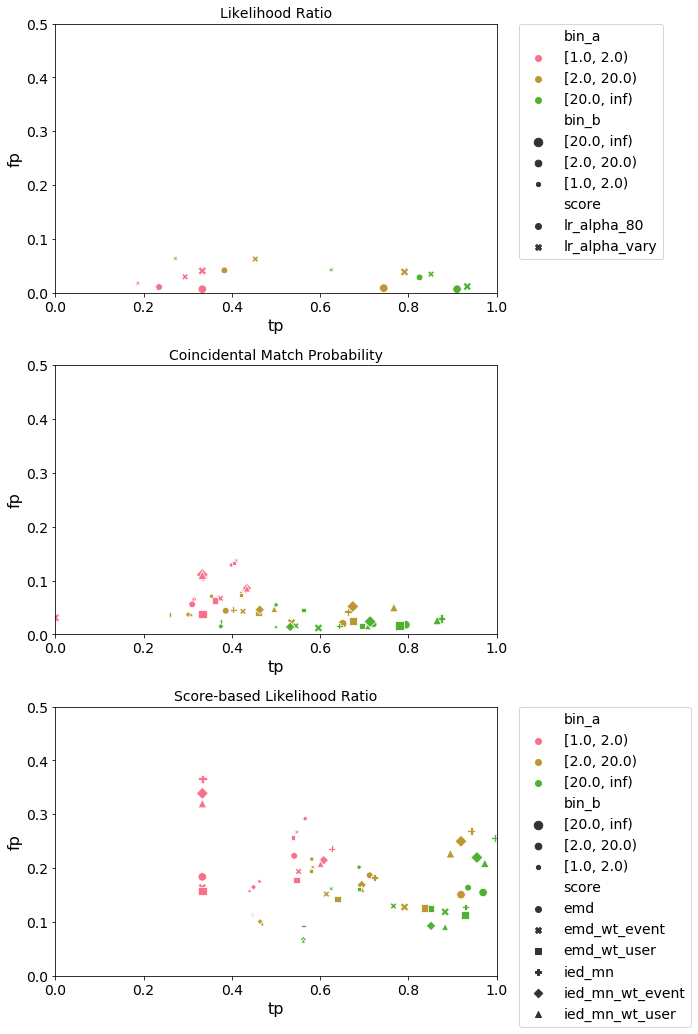

In [58]:
import matplotlib.pyplot as plt

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


sns.set_palette("husl")
xlim = (0,1)
ylim = (0,0.5)

f, axes = plt.subplots(3, 1, figsize=(10,15))

sns.scatterplot(
    x='tp', 
    y='fp', 
    data=rslt.loc[rslt.method == 'lr'], 
    hue='bin_a', 
    style='score', 
    size='bin_b',
    size_order=list(reversed(rslt.bin_b.cat.categories)),
    ax=axes[0]
).set_title("Likelihood Ratio")
axes[0].set_ylim(ylim)
axes[0].set_xlim(xlim)
axes[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

sns.scatterplot(
    x='tp', 
    y='fp', 
    data=rslt.loc[rslt.method == 'cmp'], 
    hue='bin_a', 
    style='score', 
    size='bin_b',
    size_order=list(reversed(rslt.bin_b.cat.categories)),
    ax=axes[1]
).set_title("Coincidental Match Probability")
axes[1].set_ylim(ylim)
axes[1].set_xlim(xlim)
axes[1].get_legend().remove()

sns.scatterplot(
    x='tp', 
    y='fp',
    data=rslt.loc[rslt.method == 'slr'],
    hue='bin_a', 
    style='score', 
    size='bin_b',
    size_order=list(reversed(rslt.bin_b.cat.categories)),
    ax=axes[2]
).set_title("Score-based Likelihood Ratio")
axes[2].set_ylim(ylim)
axes[2].set_xlim(xlim)
axes[2].get_legend().remove()

handles, labels = axes[2].get_legend_handles_labels()
plt.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.show()

### Simplify for DFRWS

In [59]:
sc = ['emd_wt_user', 'lr_alpha_80']
simple = rslt.loc[(rslt.bin_a == rslt.bin_b) & 
                  (rslt.score.isin(sc))]
simple['x'] = simple.bin_a.cat.codes
simple

,bin_a,bin_b,score,auc,tp,fp,method,x
77,"[1.0, 2.0)","[1.0, 2.0)",emd_wt_user,0.692,0.404,0.132,cmp,0
1,"[1.0, 2.0)","[1.0, 2.0)",lr_alpha_80,0.666,0.187,0.018,lr,0
23,"[1.0, 2.0)","[1.0, 2.0)",emd_wt_user,0.690,0.539,0.257,slr,0
101,"[2.0, 20.0)","[2.0, 20.0)",emd_wt_user,0.818,0.460,0.040,cmp,1
9,"[2.0, 20.0)","[2.0, 20.0)",lr_alpha_80,0.744,0.383,0.042,lr,1
47,"[2.0, 20.0)","[2.0, 20.0)",emd_wt_user,0.817,0.639,0.143,slr,1
125,"[20.0, inf)","[20.0, inf)",emd_wt_user,0.970,0.780,0.017,cmp,2
17,"[20.0, inf)","[20.0, inf)",lr_alpha_80,0.978,0.910,0.007,lr,2
71,"[20.0, inf)","[20.0, inf)",emd_wt_user,0.969,0.928,0.113,slr,2


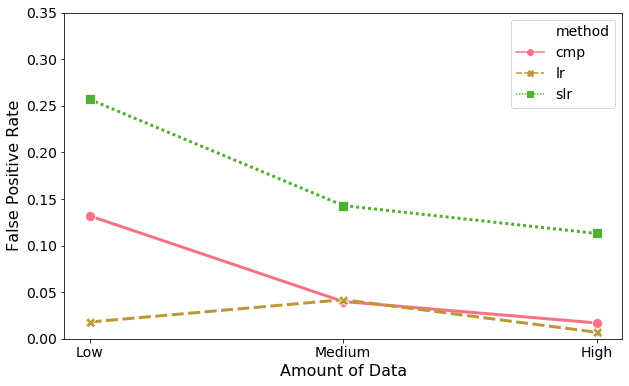

In [60]:
f, ax = plt.subplots(figsize=(10,6))

sns.lineplot(
    x='x', 
    y='fp',
    data=simple,
    hue='method',
    style='method',
    markers=True,
    markersize=10,
    linewidth=3
)
ax.set_xticklabels(['Low', 'Medium', 'High'])
ax.set_ylim((0,0.35))

plt.xticks([0,1,2])
plt.xlabel('Amount of Data')
plt.ylabel('False Positive Rate')

plt.show()

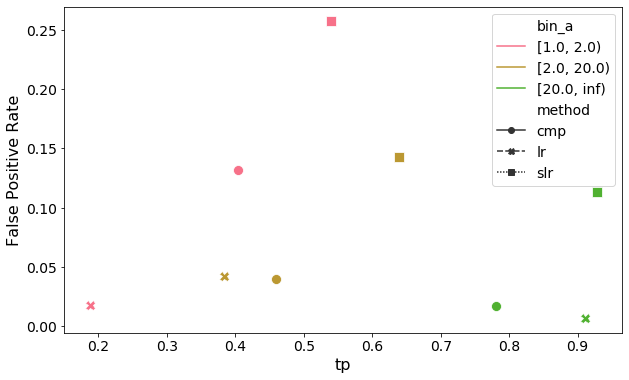

In [61]:
f, ax = plt.subplots(figsize=(10,6))

sns.lineplot(
    x='tp', 
    y='fp',
    data=simple,
    hue='bin_a',
    style='method',
    markers=True,
    markersize=10,
    linewidth=3
)
# ax.set_xticklabels(['Low', 'Medium', 'High'])

# plt.xticks([0,1,2])
# plt.xlabel('Amount of Data')
plt.ylabel('False Positive Rate')

plt.show()

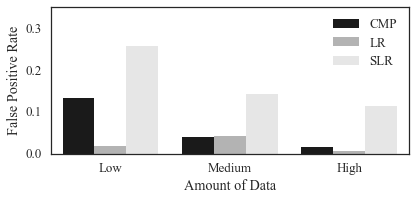

In [71]:
import matplotlib

def set_style():
    plt.style.use(['seaborn-white', 'seaborn-talk'])
    matplotlib.rc("font", family="Times New Roman")

    
def get_colors():
    return np.array([
        [0.1, 0.1, 0.1],          # black
#         [0.4, 0.4, 0.4],          # very dark gray
        [0.7, 0.7, 0.7],          # dark gray
        [0.9, 0.9, 0.9],          # light gray
    ])
        
        
def set_size(fig):
    fig.set_size_inches(6, 3)
    plt.tight_layout()

    
set_style()
sns.set_palette(get_colors())

f, ax = plt.subplots()

sns.barplot(
    x='x', 
    y='fp',
    data=simple,
    hue='method',
)
ax.set_xticklabels(['Low', 'Medium', 'High'])
ax.set_ylim((0,0.35))

legend = plt.legend()
legend.get_texts()[0].set_text('CMP')
legend.get_texts()[1].set_text('LR')
legend.get_texts()[2].set_text('SLR')

plt.xticks([0,1,2])
plt.xlabel('Amount of Data')
plt.ylabel('False Positive Rate')

set_size(f)


plt.show()

# Vignette

In [63]:
import branca.colormap as cm
from branca.element import Template, MacroElement
from collections import defaultdict
import folium
from folium.plugins import HeatMap, MarkerCluster

def calc_freqs(df):
    ### grid the population data for OC & count visits in each bin
    data = df.copy()
    data["lat_r"] = data.lat.round(3)
    data["lon_r"] = data.lon.round(3)
    freqs = (
        data.groupby(["lat_r", "lon_r"]).count().reset_index()[["lat_r", "lon_r", "event_id"]]
    )
    freqs.columns = ["lat_r", "lon_r", "freq"]
    return freqs


def get_user(mpp, uid, mark):
    out = mpp.copy()
    # out = out.drop_duplicates(subset=["location_id", "m"])
    return out.loc[(out.uid == uid) & (out.m == mark)].reset_index(drop=True)


def make_user_scatter_plot(mpp, uid, mark):
    user = get_user(mpp, uid, mark)
    return list(zip(user.lat, user.lon))


### https://nbviewer.jupyter.org/gist/talbertc-usgs/18f8901fc98f109f2b71156cf3ac81cd
template = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:20px; left: 20px; bottom: 40px;'>
     
<div class='legend-title'></div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:black;'></span>Unknown Source</li>
    <li><span style='background:red;'></span>Known Source 2</li>

  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 10px;
    width: 10px;
    -webkit-border-radius: 5px;
    -moz-border-radius: 5px;
    border-radius: 5px;
    margin-right: 5px;
    margin-left: 0;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""


def plot_heat_and_scatter(freqs, mpp, uid, loc, uidB=None, heat=True):
    if uidB is None:
        uidB = uid
    if heat:
        col = 'lightgreen'
        opacity = 0.8
    else:
        col = 'red'
        opacity = 0.75
    
    ### make the map
    if loc == 'oc':
        hmap = folium.Map(
            location=[33.585, -117.73],  # [33.68, -117.78],
            width='90%',
            zoom_start=11.5, 
            zoom_control=False,
            tiles='CartoDB positron',
        )
    elif loc =='ny':
        hmap = folium.Map(
            location=[40.735, -73.99],
            width='70%', 
            # width='60%',
            # height='95%',
#             zoom_start=12.5,
            zoom_start=11,
            zoom_control=False,
            tiles='CartoDB positron',
        )
    
    ### make the heatmap
    if heat:
        steps = 20
        color_map = cm.linear.YlOrRd_09.scale(0, 1).to_step(steps)

        gradient_map = defaultdict(dict)
        for i in range(steps):
            gradient_map[1/steps*i] = color_map.rgb_hex_str(1/steps*i)

        if loc == 'oc':
            heat = HeatMap( 
                data=list(zip(freqs['lat_r'], freqs['lon_r'], freqs['freq'])),
                min_opacity=0.2,
                max_val=float(freqs['freq'].max()),
                radius=20, 
                blur=15, 
                max_zoom=5, 
                gradient=gradient_map
            )
        
        if loc == 'ny':
            heat = HeatMap( 
                data=list(zip(freqs['lat_r'], freqs['lon_r'], freqs['freq'])),
                min_opacity=0.2,
                max_val=float(freqs['freq'].max()),
                radius=20, 
                blur=15, 
                max_zoom=5, 
                gradient=gradient_map
            )
        
        hmap.add_child(heat)
        hmap.add_child(color_map)

    ### make the scatters
    f = folium.map.FeatureGroup()
    for pt in make_user_scatter_plot(mpp, uid, 'a'):
        f.add_child(
            folium.vector_layers.CircleMarker(
                pt,
                radius=4,
                color=None,
                fill_color='black',
                fill_opacity=0.75)
        )

    for pt in make_user_scatter_plot(mpp, uidB, 'b'):
        f.add_child(
            folium.vector_layers.CircleMarker(
                pt,
                radius=4,
                color=None,
                fill_color=col,
                fill_opacity=opacity)
        )
    hmap.add_child(f)

    ### add legend
    macro = MacroElement()
    macro._template = Template(template)
    hmap.get_root().add_child(macro)

    return hmap

In [64]:
lr.sort_values(by='lr_alpha_80', ascending=False).head(20)

,a,b,lr_alpha_80,alpha,lr_alpha_vary,same-src,n_a,n_b,bin_a,bin_b
8100,6458.0,6458.0,8172.837370,0.85,8242.197620,True,1415,1226,"[20.0, inf)","[20.0, inf)"
4025,5051.0,5051.0,4274.471653,0.85,4302.865629,True,478,572,"[20.0, inf)","[20.0, inf)"
5067,5997.0,5997.0,2564.999442,0.85,2584.392719,True,309,320,"[20.0, inf)","[20.0, inf)"
686,6600.0,6600.0,2341.229457,0.85,2357.897980,True,251,275,"[20.0, inf)","[20.0, inf)"
6665,6130.0,6130.0,2191.338383,0.85,2207.109574,True,290,289,"[20.0, inf)","[20.0, inf)"
4833,5346.0,5346.0,2059.265009,0.55,1963.380838,True,31,256,"[20.0, inf)","[20.0, inf)"
5915,6469.0,6469.0,2046.964010,0.85,2056.423261,True,158,291,"[20.0, inf)","[20.0, inf)"
254,3837.0,3837.0,2003.876408,0.85,2016.861177,True,252,273,"[20.0, inf)","[20.0, inf)"
2094,6064.0,6064.0,1532.538933,0.85,1542.662226,True,167,167,"[20.0, inf)","[20.0, inf)"
4340,2031.0,2031.0,1345.764461,0.85,1364.112053,True,761,659,"[20.0, inf)","[20.0, inf)"


In [65]:
uA = 5192
plot_heat_and_scatter(freqs=None, mpp=mpp, uid=uA, loc='oc', heat=False)

In [66]:
# get users with at least one event in B at a the same location as an event in A
users_of_interest = mpp.loc[
    (mpp.location_id.isin(mpp.loc[mpp.uid == uA].location_id.unique())) &
    (mpp.m == 'b') &
    (mpp.uid != uA)
].uid.unique()
print(len(users_of_interest))

cts_b.loc[cts_b.uid.isin(users_of_interest)].sort_values(by='n_b', ascending=False).head(10)

270


,uid,n_b
11993,5997,320
11211,5606,92
12627,6314,79
6279,3140,67
6281,3141,67
9309,4655,67
6289,3145,67
6283,3142,67
2987,1494,66
1199,600,60


In [67]:
uB = 5606
plot_heat_and_scatter(freqs=None, mpp=mpp, uid=uA, uidB=uB, loc='oc', heat=False)

In [68]:
np.exp(calculate_lr(mpp, pop_kde_data, uA=uA, uB=uB))

1.9493051906100332e-27

In [69]:
mpp.loc[
    (mpp.uid == uB) &
    (mpp.m == 'b') &
    (mpp.location_id.isin(mpp.loc[mpp.uid == uA].location_id.unique()))
]

,old_uid,uid,m,lon,lat,location_id,weight_event,weight_user
15101,1.549946e+09,5606,b,-117.72027,33.56363,1195.0,0.008772,0.024390
15102,1.549946e+09,5606,b,-117.71972,33.56416,1195.0,0.008772,0.024390
18034,1.549946e+09,5606,b,-117.70848,33.56839,346014.0,0.009804,0.014925
25295,1.549946e+09,5606,b,-117.72670,33.57558,5931.0,0.035714,0.040000
41033,1.549946e+09,5606,b,-117.72712,33.57456,5932.0,0.041667,0.058824
